goal here is to do the signature scoring on the AD data and see if we can eliminate batch-specific differences

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

#For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)
#Set style
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from matplotlib.colors import ListedColormap

from scipy.stats import mannwhitneyu

np.random.seed(31)

In [2]:
# source data path for publication
sourceDataPath = "/Users/kayaneh/Documents/deconvolution/aip/source_data/fig2_sourceData.xlsx"

In [3]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

In [4]:
adCPMTMM = pd.read_csv("~/Documents/deconvolution/alzheimers/remapped_unstranded/ad_cpmTMM_postQC_unstranded_FINAL.csv",
                      sep = ",", index_col = [0, 1])

# make the column space in ENSG ID
adCPMTMM.reset_index(inplace = True)
adCPMTMM.set_index("gene_num", inplace = True)
adCPMTMM.drop("gene_name", inplace = True, axis = "columns")

In [5]:
adCPMTMM = np.log(adCPMTMM + 1)

In [6]:
adMeta = pd.read_csv("~/Documents/deconvolution/alzheimers/remapped_unstranded/allAD_metadata_FINAL.csv",
                    sep = ",", index_col = 0)

In [7]:
adMeta.shape

(339, 40)

In [8]:
adCPMTMM.columns = [int(i) for i in adCPMTMM.columns]

In [9]:
# subset the metadata to the samples passing QC
adMeta = adMeta.loc[adCPMTMM.columns]

In [10]:
# there's a weird nan 
adMeta = adMeta[adMeta["Disease"].isin(["NCI", "AD"])]

In [11]:
kyMeta = adMeta[adMeta["Center"] == "University of Kentucky"]

In [12]:
kyMeta = kyMeta[~kyMeta.index.duplicated(keep='first')]

In [13]:
np.unique(kyMeta["Disease"],
         return_counts = True)

(array(['AD', 'NCI'], dtype=object), array([40, 18]))

In [14]:
adCPMTMM = adCPMTMM[np.unique(adMeta.index)]

In [15]:
adCPMTMM.shape

(60721, 158)

In [16]:
adBase = "~/Documents/deconvolution/alzheimers/"
brainGiniPath_HEALTHY = adBase + "gini6_perCluster_brain_NORMAL_01212021.csv"
brainGiniPath_AD = adBase + "gini6_perCluster_brain_AZ_01212021.csv"

In [17]:
brainHealthy = pd.read_csv(brainGiniPath_HEALTHY, index_col = 0)
brainAD = pd.read_csv(brainGiniPath_AD, index_col = 0)

In [18]:
brainSigs = {}
for i in brainAD:
    brainSigs[i] = np.intersect1d(brainAD[i].dropna().index.tolist(), brainHealthy[i].dropna().index.tolist()).tolist()


# do the signature scoring

In [19]:
"""
@param countsDF = dataframe with log-transformed CPM-TMM counts
@param sigDict = dictionary with keys of str that are cell types and 
                values are lists of their unique marker genes
"""

def cis(countsDF, sigDict):
    cisRes = pd.DataFrame()
    for cell in sigDict:  
        geneList = sigDict[cell]
        intersection = np.intersect1d(geneList, countsDF.index.tolist())
        
        cellSig = countsDF.loc[intersection].sum(axis = 0).to_frame()
        cellSig.columns = [cell + "-CIS"]
        cisRes = pd.concat([cisRes, cellSig], axis = 1)
        
    return(cisRes)

In [20]:
adCIS = cis(adCPMTMM, brainSigs)

In [21]:
# tack on the metadata
adCIS = adCIS.join(adMeta.iloc[:,-10:])

In [22]:
adCIS.drop_duplicates(subset = "Isolate", keep = "first", inplace = True)

In [23]:
adCIS.index == adCIS["Isolate"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [24]:
meltADCIS = pd.melt(adCIS, value_vars = adCIS.columns[:-10],
                   id_vars = adCIS.columns[-10:])

In [25]:
diseaseVar = []
for i in range(meltADCIS.shape[0]):
    res = meltADCIS["variable"][i] + "-" + meltADCIS["Disease"][i]
    diseaseVar += [res]

In [26]:
meltADCIS["disease_var"] = diseaseVar

In [27]:
kyOnly = meltADCIS[meltADCIS["Center"] == "University of Kentucky"]

In [28]:
disease_pal = {}
for i in np.unique(kyOnly["disease_var"]):
    if "AD" in i: disease_pal[i] = "#cae9ff"
    else: disease_pal[i] = "#5FA8D3"

In [29]:
goodCells = ["Ast-gini-CIS", "Ex-gini-CIS", "Oli-gini-CIS", "Opc-gini-CIS"]

In [30]:
kyGoodCell = kyOnly[kyOnly["variable"].isin(goodCells)]

In [31]:
cogFn = []
for i in kyGoodCell["MMSE"]:
    i = int(i)
    if i >= 24: cogFn += ["Normal"]
    elif 19 <= i < 24: cogFn += ["Mild Dementia"]
    elif 10 <= i < 19: cogFn += ["Moderate Dementia"]
    else: cogFn += ["Severe Dementia"]

In [32]:
kyGoodCell["mmseCategory"] = cogFn

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


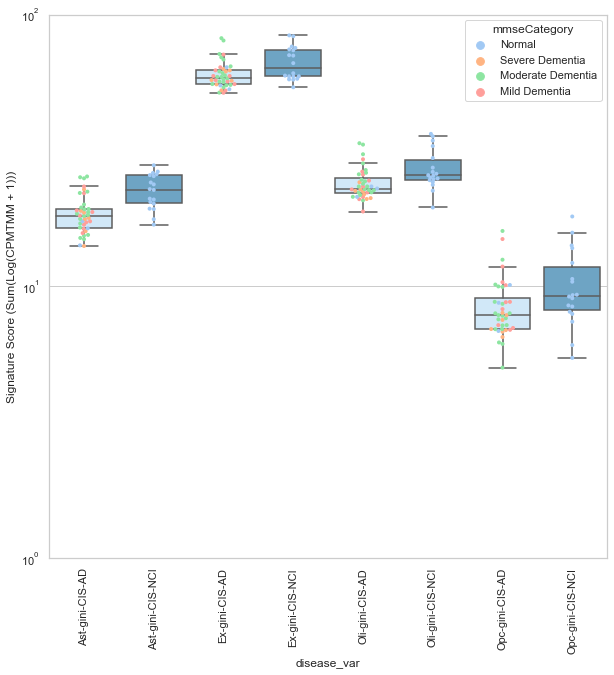

In [33]:
plt.figure(figsize = (10, 10))
plt.semilogy()

sns.boxplot(data = kyGoodCell, x = "disease_var",
           y = "value", 
            #hue = "Disease",
           palette = disease_pal,
            fliersize = 0)

sns.swarmplot(data = kyGoodCell, x = "disease_var",
              hue = "mmseCategory",
              y = "value", size = 4)

plt.ylabel("Signature Score (Sum(Log(CPMTMM + 1)))")
plt.ylim((1, 100))
plt.xticks(rotation = "90");

In [34]:
desOrder = ['Ast-gini-CIS-NCI', 'Ast-gini-CIS-AD', 
            'Ex-gini-CIS-NCI', 'Ex-gini-CIS-AD',
           'Oli-gini-CIS-NCI', 'Oli-gini-CIS-AD',
           'Opc-gini-CIS-NCI', 'Opc-gini-CIS-AD']

([<matplotlib.axis.YTick at 0x7fb1901be978>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

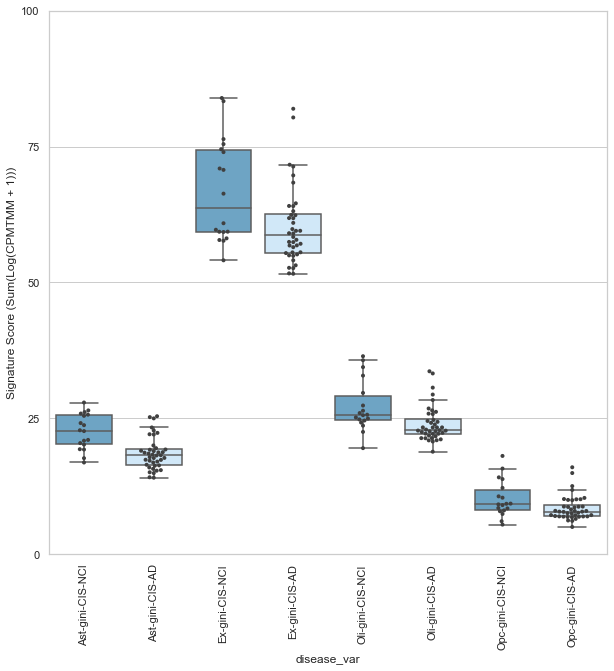

In [35]:
plt.figure(figsize = (10, 10))

sns.boxplot(data = kyGoodCell, x = "disease_var",
           y = "value", 
           palette = disease_pal,
            order = desOrder,
            fliersize = 0)

sns.swarmplot(data = kyGoodCell, x = "disease_var",
              color = "0.25",
              order = desOrder,
              y = "value", size = 4)

plt.ylabel("Signature Score (Sum(Log(CPMTMM + 1)))")

plt.ylim((0, 100))

plt.xticks(rotation = "90");
plt.yticks(np.arange(0, 101, 25))
#save_figure_pdf(plt, "ad_sigScore_astExOliOpc_09082021.pdf")

In [36]:
with pd.ExcelWriter(sourceDataPath, mode = 'a') as writer:
            kyGoodCell[['Center', 'Disease', 'Isolate', 'variable', 'value', 'disease_var']].to_excel(writer, sheet_name = 'AD', engine = 'xlsxwriter')

In [37]:
cellTypeUVals = {}
for celltype in np.unique(kyOnly["variable"]):
    ctCIS = kyOnly[kyOnly["variable"] == celltype]
    adList = ctCIS[ctCIS["Disease"] == "AD"]["value"].tolist()
    nciList = ctCIS[ctCIS["Disease"] == "NCI"]["value"].tolist()
    if celltype == "Ex-gini-CIS":
        u, p = mannwhitneyu(adList, nciList, alternative = "less")
    else: 
        u, p = mannwhitneyu(adList, nciList, alternative = "two-sided")
    cellTypeUVals[celltype] = u
    print(celltype, u, p)

Ast-gini-CIS 121.0 6.109402446976773e-05
Ex-gini-CIS 206.0 0.004941116975336617
In-gini-CIS 391.0 0.6082149618243848
Mic-gini-CIS 170.0 0.0014476080728198192
Oli-gini-CIS 178.0 0.0022843947135658595
Opc-gini-CIS 224.0 0.02276286699352783


# now perform the permutation test

In [ ]:
np.random.seed(10)

pValDict = {}
differenceDict = {}
uDict = {}
for celltype in np.unique(kyOnly["variable"]):
    print(celltype)
    ctCIS = kyOnly[kyOnly["variable"] == celltype]
    
    pvals = []
    difference = []
    uList = []
    for i in range(10000):
        newLabels = np.random.permutation(ctCIS["Disease"])
        
        ctCIS['shuffled'] = newLabels


        ad = ctCIS[ctCIS['shuffled'] == "AD"]['value'].values.tolist()
        nci = ctCIS[ctCIS['shuffled'] == "NCI"]["value"].values.tolist()
            
        if celltype == "Ex-gini-CIS":
            u_permute, p_permute = mannwhitneyu(ad, nci, alternative = "less")
        else:
            u_permute, p_permute = mannwhitneyu(nci, ad, alternative = "two-sided")
        
        
        difference += [np.mean(nci) - np.mean(ad)]
        uList += [u_permute]
        pvals += [p_permute]
        
    pValDict[celltype] = pvals
    differenceDict[celltype] = difference
    uDict[celltype] = uList

In [ ]:
cellTypeUVals

In [ ]:
for i in uDict:
    if "Ast" in i or "Ex" in i or "Oli" in i or "Opc" in i:
        sns.histplot(uDict[i], color = "#62B6CB")
        plt.axvline(x = cellTypeUVals[i], color = "red")
        plt.title(i)
        save_figure_pdf(plt, i + '-uDistUnderNull.pdf')
        plt.show()

In [ ]:
for i in pValDict:
    if "Ast" in i or "Ex" in i or "Oli" in i or "Opc" in i:
        sns.histplot(pValDict[i], color = "#62B6CB")
        
        plt.title(i)
        save_figure_pdf(plt, i + '_pvalDist.pdf')
        plt.show()

In [ ]:
clear all